In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np

from PIL import ImageDraw

plt.ion()   # interactive mode

In [2]:
def get_grid(thetas, idx):
    theta = thetas[idx]
    grid = F.affine_grid(theta.view(1, 2, 3), torch.Size([1, 1, 28, 28]))
    grid = 60*(grid[0] + 1) / 2 # undo normalization of image coordinates
    return grid

def convert_img(single_image):
    single_pil = transforms.ToPILImage()(single_image)
    # clip image, for visualization purposes
    thresh = lambda x : 255 if x > 150 else 0
    single_pil = single_pil.convert('L').point(thresh, mode='1')
    single_pil = single_pil.convert('RGB')
    return single_pil

def draw_box(pil_image, grid):
    draw = ImageDraw.Draw(pil_image)
    # Match colors from the paper
    draw.line([*grid[0][0], *grid[0][-1]], fill='red')
    draw.line([*grid[0][-1], *grid[-1][-1]], fill='green')
    draw.line([*grid[-1][-1], *grid[-1][0]], fill='yellow')
    draw.line([*grid[-1][0], *grid[0][0]], fill='blue')

    return pil_image

In [78]:
def train(epoch, log_freq=500):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # negative log-likelihood
        loss.backward()
        optimizer.step()
        if batch_idx % log_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()
            
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input is single channel, deepen here
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # Two FC layers to classify
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # ST localization network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 11 * 11, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    # This also allows for the localization to be called separately on test data
    def stn(self, x):
        theta = self.theta(x)
        # Scale to NxCx28x28, essentially downsizing
        grid = F.affine_grid(theta, torch.Size([x.shape[0], x.shape[1], 28, 28]))
        x = F.grid_sample(x, grid)

        return x

    def theta(self, x):
        xs = self.localization(x)
        # Got this shape by simply running a single forward pass and printing the dimensions of `self.localization`
        xs = xs.view(-1, 10 * 11 * 11)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        return theta

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [54]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=True, transform=transforms.Compose([
        transforms.Pad(16), # Make larger
        transforms.RandomAffine(0, translate=(0.4, 0.4)), # Random shift
        transforms.ToTensor()#,
        # transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.Pad(16),
        transforms.RandomAffine(0, translate=(0.4, 0.4)),
        transforms.ToTensor()#,
        # transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [71]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 25], gamma=0.1)
for epoch in range(201):
    train(epoch)
    test()
    print('-'*20)
    scheduler.step()

000 (53%)]	Loss: 1.349076

Test set: Average loss: 1.2707, Accuracy: 5801/10000 (58%)

--------------------
Train Epoch: 91 [0/60000 (0%)]	Loss: 1.458036
Train Epoch: 91 [32000/60000 (53%)]	Loss: 1.400326

Test set: Average loss: 1.2653, Accuracy: 6024/10000 (60%)

--------------------
Train Epoch: 92 [0/60000 (0%)]	Loss: 1.303803
Train Epoch: 92 [32000/60000 (53%)]	Loss: 1.624267

Test set: Average loss: 1.2569, Accuracy: 5923/10000 (59%)

--------------------
Train Epoch: 93 [0/60000 (0%)]	Loss: 1.271129
Train Epoch: 93 [32000/60000 (53%)]	Loss: 1.726619

Test set: Average loss: 1.2498, Accuracy: 5938/10000 (59%)

--------------------
Train Epoch: 94 [0/60000 (0%)]	Loss: 1.609830
Train Epoch: 94 [32000/60000 (53%)]	Loss: 1.534604

Test set: Average loss: 1.2501, Accuracy: 5833/10000 (58%)

--------------------
Train Epoch: 95 [0/60000 (0%)]	Loss: 1.421117
Train Epoch: 95 [32000/60000 (53%)]	Loss: 1.499521

Test set: Average loss: 1.2388, Accuracy: 5952/10000 (60%)

------------------

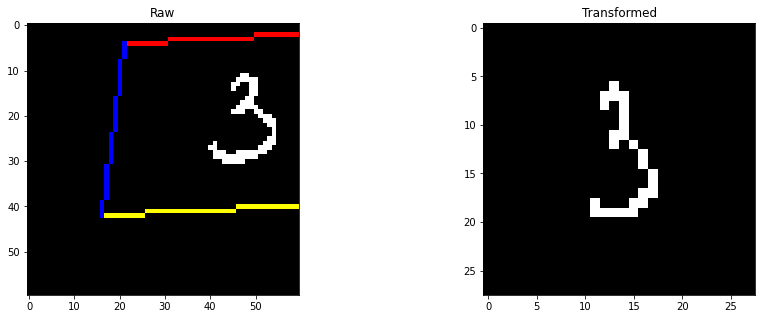

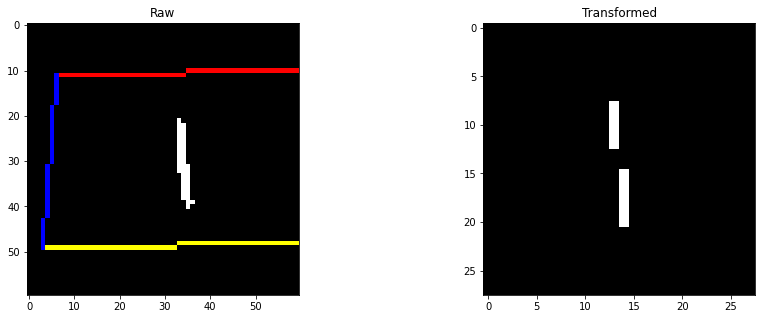

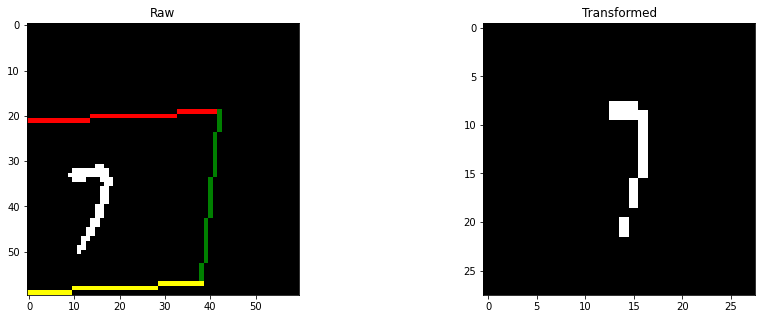

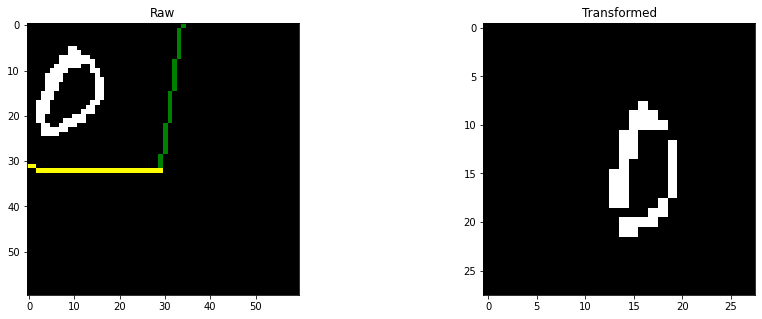

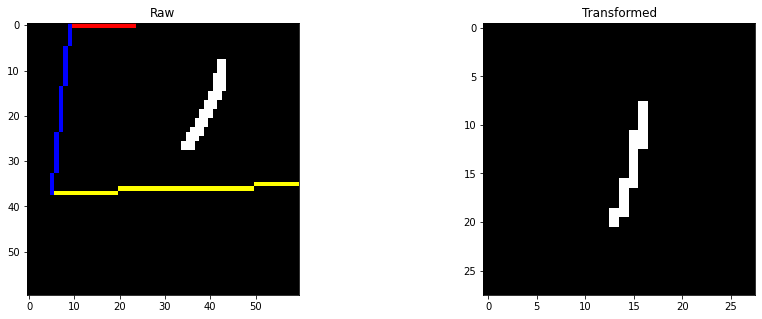

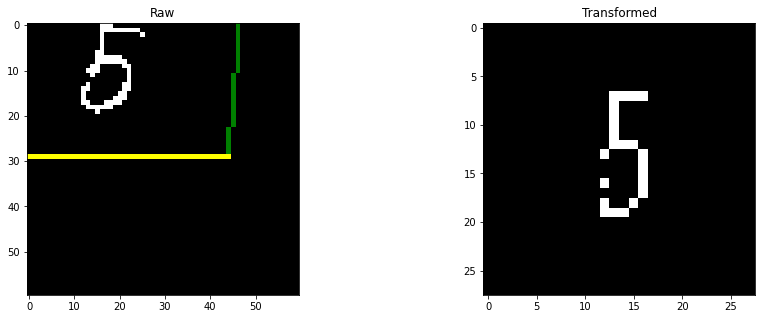

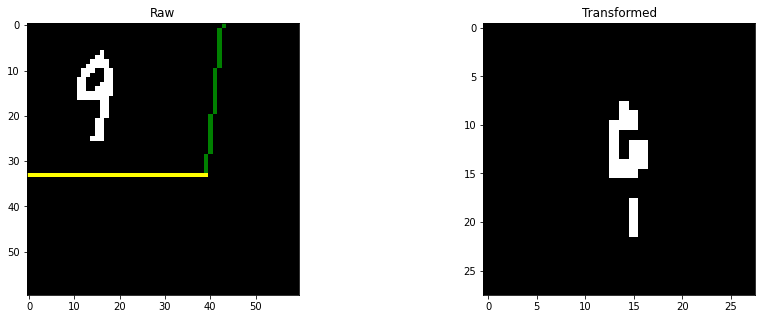

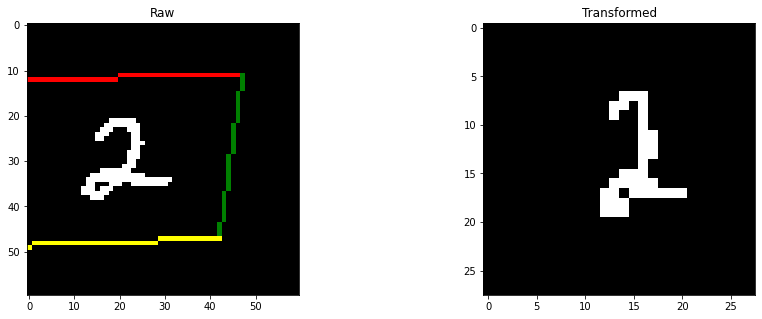

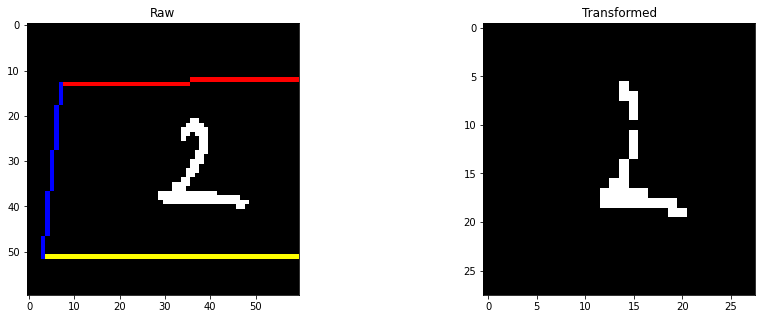

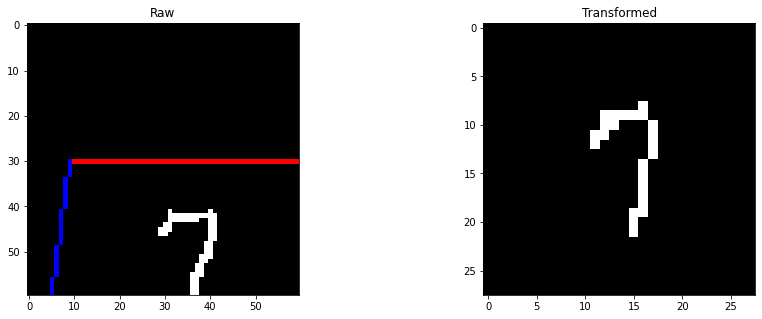

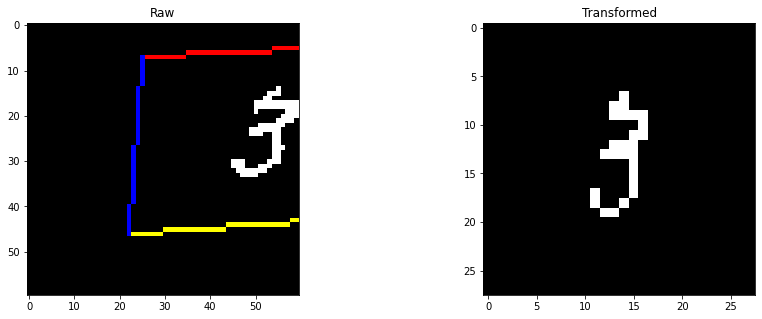

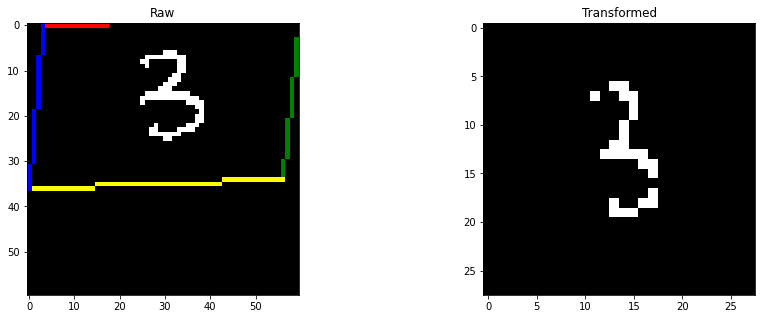

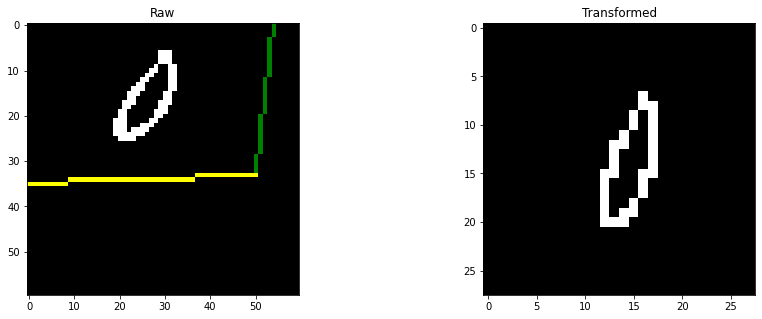

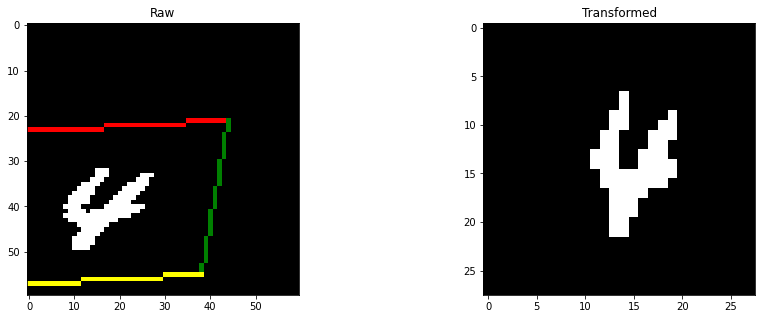

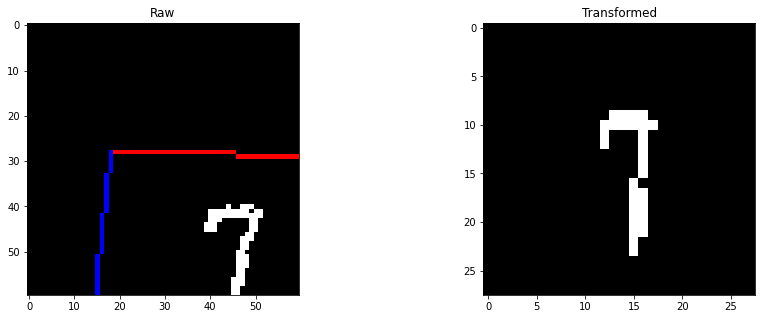

In [72]:
single_batch = next(iter(test_loader))[0].cuda()

with torch.no_grad():
    tformed_batch = model.stn(single_batch)
    thetas = model.theta(single_batch)

single_batch = single_batch.cpu()
tformed_batch = tformed_batch.cpu()
thetas = thetas.cpu()

for i in range(15): # Show only 15 examples
    img = convert_img(single_batch[i,:,:,:])
    grid = get_grid(thetas, i)
    draw_box(img, grid)
    
    tformed_img = convert_img(tformed_batch[i,:,:,:])
    
    _, axs = plt.subplots(1, 2)
    axs[0].imshow(img)
    axs[0].set_title('Raw')

    axs[1].imshow(tformed_img)
    axs[1].set_title('Transformed')
    plt.show()
    

In [74]:
torch.save({
    'epoch' : 200,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'weights/checkpoint.pkl')

In [75]:
for epoch in range(200, 301):
    train(epoch)
    test()
    print('-'*20)
    scheduler.step()

Train Epoch: 200 [0/60000 (0%)]	Loss: 0.809215
Train Epoch: 200 [32000/60000 (53%)]	Loss: 0.864889

Test set: Average loss: 0.7343, Accuracy: 7993/10000 (80%)

--------------------
Train Epoch: 201 [0/60000 (0%)]	Loss: 0.810323
Train Epoch: 201 [32000/60000 (53%)]	Loss: 0.904779

Test set: Average loss: 0.7313, Accuracy: 7927/10000 (79%)

--------------------
Train Epoch: 202 [0/60000 (0%)]	Loss: 1.037554
Train Epoch: 202 [32000/60000 (53%)]	Loss: 0.825803

Test set: Average loss: 0.7192, Accuracy: 7989/10000 (80%)

--------------------
Train Epoch: 203 [0/60000 (0%)]	Loss: 1.165933
Train Epoch: 203 [32000/60000 (53%)]	Loss: 1.013544

Test set: Average loss: 0.7202, Accuracy: 8002/10000 (80%)

--------------------
Train Epoch: 204 [0/60000 (0%)]	Loss: 0.969665
Train Epoch: 204 [32000/60000 (53%)]	Loss: 0.862032

Test set: Average loss: 0.7087, Accuracy: 8019/10000 (80%)

--------------------
Train Epoch: 205 [0/60000 (0%)]	Loss: 0.890885
Train Epoch: 205 [32000/60000 (53%)]	Loss: 1.117

In [80]:
def show_tforms(num_to_show=15):
    single_batch = next(iter(test_loader))[0].cuda()

    with torch.no_grad():
        tformed_batch = model.stn(single_batch)
        thetas = model.theta(single_batch)

    single_batch = single_batch.cpu()
    tformed_batch = tformed_batch.cpu()
    thetas = thetas.cpu()

    for i in range(num_to_show):
        img = convert_img(single_batch[i,:,:,:])
        grid = get_grid(thetas, i)
        draw_box(img, grid)
        
        tformed_img = convert_img(tformed_batch[i,:,:,:])
        
        _, axs = plt.subplots(1, 2)
        axs[0].imshow(img)
        axs[0].set_title('Raw')

        axs[1].imshow(tformed_img)
        axs[1].set_title('Transformed')
        plt.show()

In [77]:
torch.save({
    'epoch' : 300,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'weights/checkpoint.pkl')

In [79]:
for epoch in range(301, 400):
    train(epoch, log_freq=1000)
    test()
    print('-'*20)
    scheduler.step()

Train Epoch: 301 [0/60000 (0%)]	Loss: 0.685044

Test set: Average loss: 0.4655, Accuracy: 8727/10000 (87%)

--------------------
Train Epoch: 302 [0/60000 (0%)]	Loss: 0.560839

Test set: Average loss: 0.4600, Accuracy: 8786/10000 (88%)

--------------------
Train Epoch: 303 [0/60000 (0%)]	Loss: 1.025373

Test set: Average loss: 0.4679, Accuracy: 8738/10000 (87%)

--------------------
Train Epoch: 304 [0/60000 (0%)]	Loss: 0.721437

Test set: Average loss: 0.4601, Accuracy: 8772/10000 (88%)

--------------------
Train Epoch: 305 [0/60000 (0%)]	Loss: 0.706098

Test set: Average loss: 0.4553, Accuracy: 8801/10000 (88%)

--------------------
Train Epoch: 306 [0/60000 (0%)]	Loss: 0.520823

Test set: Average loss: 0.4518, Accuracy: 8804/10000 (88%)

--------------------
Train Epoch: 307 [0/60000 (0%)]	Loss: 0.682990

Test set: Average loss: 0.4574, Accuracy: 8765/10000 (88%)

--------------------
Train Epoch: 308 [0/60000 (0%)]	Loss: 0.958783

Test set: Average loss: 0.4500, Accuracy: 8814/10

In [84]:
torch.save({
    'epoch' : 400,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'weights/checkpoint.pkl')

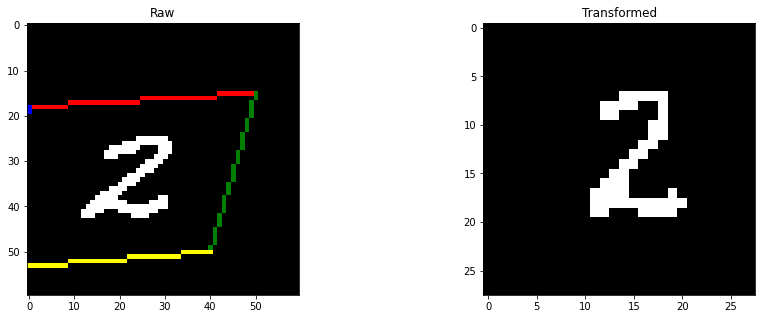

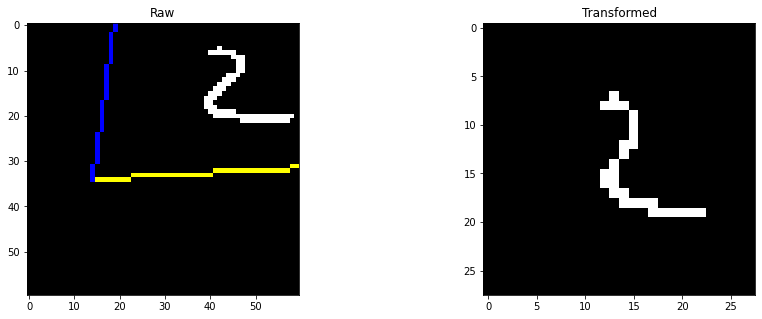

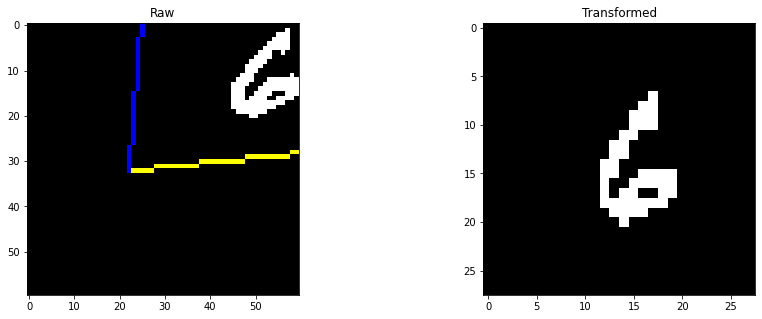

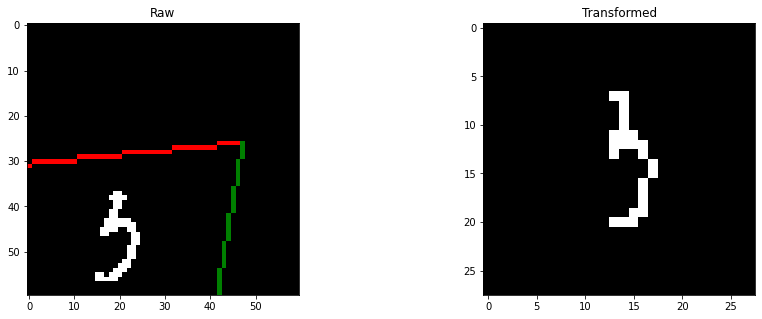

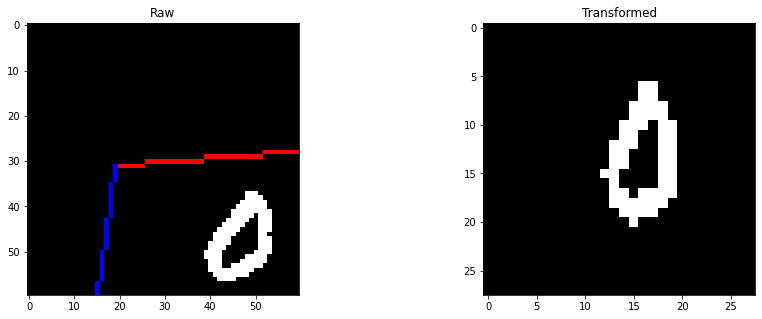

In [81]:
show_tforms(5)

In [87]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.RandomAffine(90),#, translate=(0.4, 0.4)),
        transforms.Pad(16),
        # transforms.RandomAffine(0, translate=(0.4, 0.4)),
        transforms.ToTensor()#,
        # transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

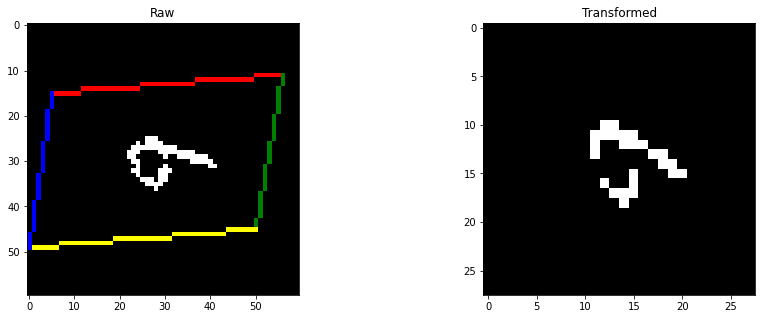

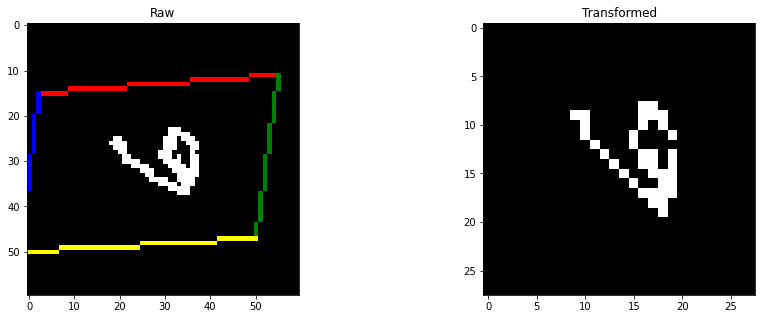

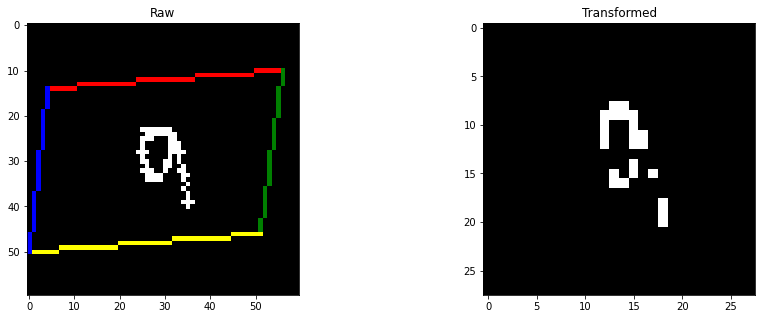

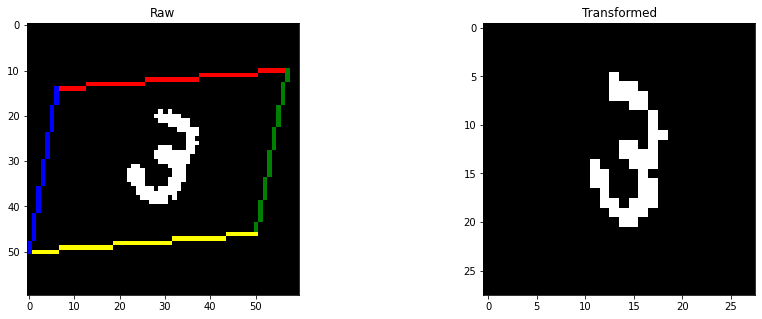

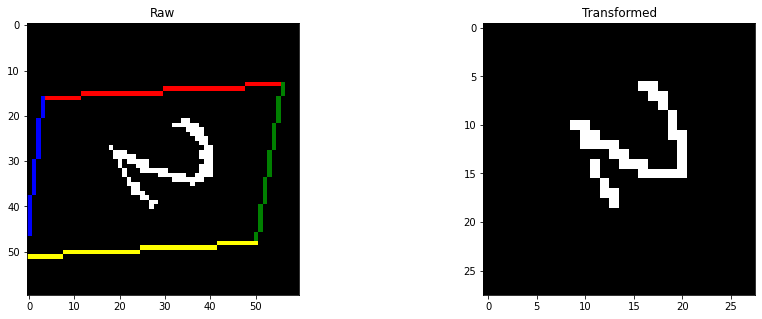

In [88]:
show_tforms(5)

In [89]:
test()


Test set: Average loss: 3.8086, Accuracy: 4240/10000 (42%)



In [90]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=True, transform=transforms.Compose([
        transforms.RandomAffine(90),
        transforms.Pad(16),
        transforms.ToTensor()
    ])), batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.RandomAffine(90),
        transforms.Pad(16),
        transforms.ToTensor()
    ])), batch_size=64, shuffle=True, num_workers=4)

In [91]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 25, 50], gamma=0.1)
for epoch in range(201):
    train(epoch)
    test()
    print('-'*20)
    scheduler.step()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.326465
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.301281

Test set: Average loss: 2.2918, Accuracy: 2402/10000 (24%)

--------------------
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301288
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.267765

Test set: Average loss: 2.2393, Accuracy: 3126/10000 (31%)

--------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.247736
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.032890

Test set: Average loss: 1.8388, Accuracy: 4368/10000 (44%)

--------------------
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.181066
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.869419

Test set: Average loss: 1.4340, Accuracy: 5455/10000 (55%)

--------------------
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.606373
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.302761

Test set: Average loss: 0.9492, Accuracy: 7464/10000 (75%)

--------------------
Train Epoch: 5 [0/60000 (0%)]	Loss: 1.398319
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.212952

Test set: Average l

KeyboardInterrupt: 

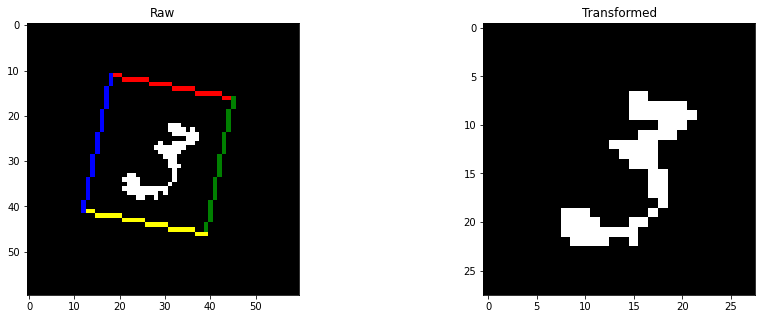

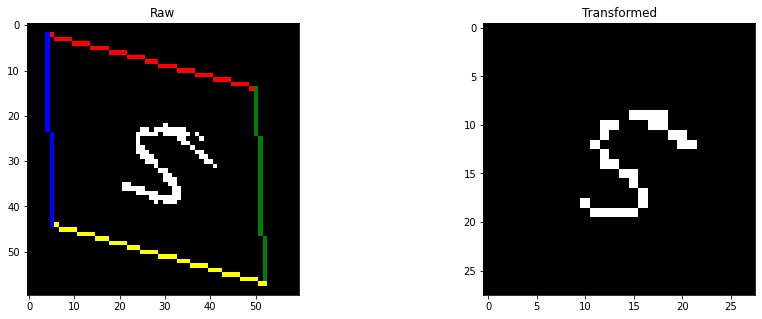

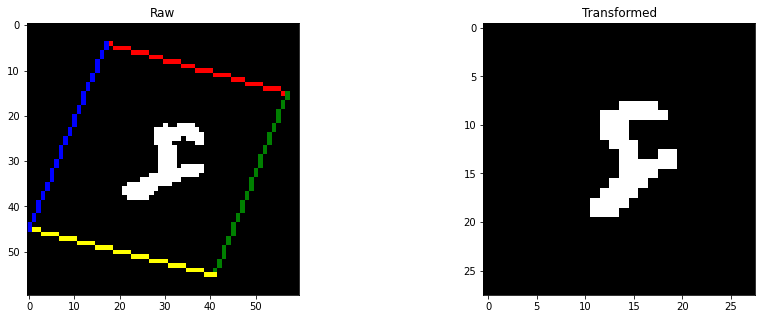

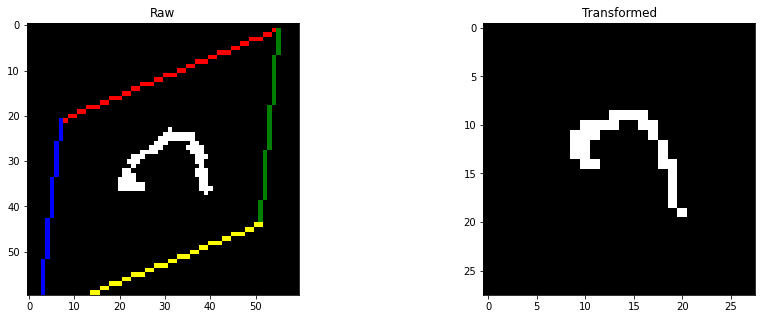

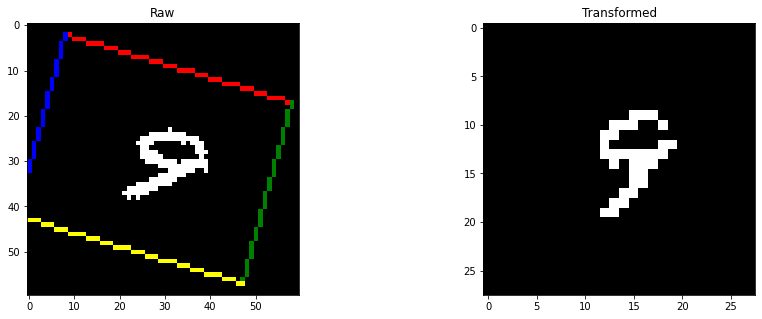

In [92]:
show_tforms(5)

In [95]:
torch.save({
    'epoch' : 87,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'weights/rotation_checkpoint.pkl')

In [97]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=True, transform=transforms.Compose([
        transforms.RandomAffine(180),
        transforms.Pad(16),
        transforms.ToTensor()
    ])), batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data/', train=False, transform=transforms.Compose([
        transforms.RandomAffine(180),
        transforms.Pad(16),
        transforms.ToTensor()
    ])), batch_size=64, shuffle=True, num_workers=4)

In [98]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 25, 50], gamma=0.1)
for epoch in range(101):
    train(epoch)
    test()
    print('-'*20)
    scheduler.step()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.323773
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.308321

Test set: Average loss: 2.2931, Accuracy: 1950/10000 (20%)

--------------------
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292576
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.295748

Test set: Average loss: 2.2339, Accuracy: 2407/10000 (24%)

--------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.248119
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.155792

Test set: Average loss: 1.9187, Accuracy: 3428/10000 (34%)

--------------------
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.092339
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.011666

Test set: Average loss: 1.6611, Accuracy: 4547/10000 (45%)

--------------------
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.748087
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.702497

Test set: Average loss: 1.6383, Accuracy: 4276/10000 (43%)

--------------------
Train Epoch: 5 [0/60000 (0%)]	Loss: 1.858255
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.402411

Test set: Average l